In [1]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add("DotMaps")
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev")
@suppress Pkg.add(["Dates","Plots","DataFrames"])
@info "Dependencies added"

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Precompiling project...


  ✓ BenchmarkTools


  ✓ LazyJSON


  ✓ Unmarshal


  ✓ Latexify → DataFramesExt


  ✓ BangBang → BangBangDataFramesExt


  ✓ DirectSearch


  ✓ Transducers → TransducersDataFramesExt


  ✓ CSV


  ✓ Parquet2


  ✓ Plots


  ✓ Plots → FileIOExt


  ✓ Plots → UnitfulExt


  ✓ MathOptInterface


  ✓ Ipopt


  ✓ JuMP


  ✓ AirBorne


  16 dependencies successfully precompiled in 227 seconds. 236 already precompiled.
  1 dependency had output during precompilation:
┌ Unmarshal [cbff2730-442d-58d7-89d1-8e530c41eb02]
│  WARNING: method definition for unmarshal at /Users/sherifagbabiaka/.julia/packages/Unmarshal/2eEFB/src/Unmarshal.jl:67 declares type variable N but does not use it.
└  


┌ Info: Dependencies added
└ @ Main /Users/sherifagbabiaka/Documents/uni-4/FYP/fyp_repo/test.ipynb:6


In [2]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL", "GOOG"], unix("2017-01-01"), unix("2022-01-01"))

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,29.0375,29.0825,28.69,28.95,115127600,2017-01-03T09:30:00,1483453800,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,29.005,29.1275,28.9375,28.9625,84472400,2017-01-04T09:30:00,1483540200,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,29.1525,29.215,28.9525,28.98,88774400,2017-01-05T09:30:00,1483626600,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,29.4775,29.54,29.1175,29.195,127007600,2017-01-06T09:30:00,1483713000,NMS,America/New_York,USD,AAPL,NMS/AAPL
5,29.7475,29.8575,29.485,29.4875,134247600,2017-01-09T09:30:00,1483972200,NMS,America/New_York,USD,AAPL,NMS/AAPL
6,29.7775,29.845,29.575,29.6925,97848400,2017-01-10T09:30:00,1484058600,NMS,America/New_York,USD,AAPL,NMS/AAPL
7,29.9375,29.9825,29.65,29.685,110354400,2017-01-11T09:30:00,1484145000,NMS,America/New_York,USD,AAPL,NMS/AAPL
8,29.8125,29.825,29.5525,29.725,108344800,2017-01-12T09:30:00,1484231400,NMS,America/New_York,USD,AAPL,NMS/AAPL
9,29.76,29.905,29.7025,29.7775,104447600,2017-01-13T09:30:00,1484317800,NMS,America/New_York,USD,AAPL,NMS/AAPL


In [10]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using DataFrames: DataFrame, groupby, combine, mean
#using AirBorne.Strategies.SMA: interday_initialize!, interday_trading_logic!
# include("./EMA.jl")
include("./MovingAverage.jl")
#using .EMA: interday_initialize!, interday_trading_logic!
using AirBorne.Structures: summarizePerformance,TimeEvent
using Dates: DateTime
using DirectSearch
using PaddedViews

#  in a given amount of time, how many local optima can we find?
# consider using smoothing data optimisers
# noisy data optimisers - DirectSerarch -> compare with derivative based/noise sensitive

function weightings(prices, window)
    weights = [1,2,4,8,16]
    price_window = last(prices, length(weights))
    # price_window = PaddedView(0.0, price_window, window)
    # print(price_window)
    tmp = sum(weights .* price_window) / sum(weights)
    return sum(weights .* price_window) / sum(weights)
    #return mean(last(prices, window))
end
# try interpolation for custom weights -> structure may not be clear

function obj(x)
    avg_initialize!(context) = MovingAverage.interday_initialize!(context; 
        longHorizon=x[2], shortHorizon=x[1], initialCapital=10^4, averagingType=:simple)
    avg_trading_logic! = MovingAverage.interday_trading_logic!
    # Run Simulation
    # max_iter = 100

    evaluationEvents = [
            TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
        ]

    @time context = run(
        data,
        avg_initialize!,
        avg_trading_logic!,
        execute_orders!,
        expose_data;
        audit=true,
        max_date=DateTime(2022, 1, 1),
        verbose=false,
        initialEvents=evaluationEvents,
    )

    results = summarizePerformance(data, context)
    # print(results)
    return -results.dollarValue[end]
end
# try fixing one var and optimising the other -> compute derivatives: if similar maybe a mixed integer LP
# JuMP.jl -> zygote.jl, reverse dif, forward dif
# Flux.jl -> auto dif
println("Done")
p = DSProblem(2, objective=obj)
# x is a vector of length 2, containing the window sizes in the form (short, long)
# obj(x) = sum(ema(data.close, x[1]) .- ema(data.close, x[2]))
SetInitialPoint(p, [1.0, 100.0])
SetGranularity(p, [1, 1])
slcond(x) = x[1] < x[2]
valcond(x) = x[1] > 0 && x[2] > 0 && x[1] <= 100 && x[2] <= 100
AddExtremeConstraint(p, slcond)
AddExtremeConstraint(p, valcond)
Optimize!(p)

Done


  2.733037 seconds (8.21 M allocations: 839.503 MiB, 12.54% gc time, 20.70% compilation time)


  1.685941 seconds (6.27 M allocations: 716.731 MiB, 15.83% gc time)


  1.477561 seconds (5.22 M allocations: 651.119 MiB, 14.53% gc time)


  2.096302 seconds (6.19 M allocations: 711.438 MiB, 14.23% gc time)


  1.452287 seconds (5.42 M allocations: 663.047 MiB, 14.83% gc time)


  1.406249 seconds (5.25 M allocations: 653.130 MiB, 14.14% gc time)


  2.583837 seconds (9.66 M allocations: 927.740 MiB, 14.79% gc time)


  1.654883 seconds (5.25 M allocations: 652.049 MiB, 15.40% gc time)


  1.659428 seconds (5.99 M allocations: 699.091 MiB, 13.52% gc time)


  1.448287 seconds (5.54 M allocations: 671.121 MiB, 14.60% gc time)


  1.514767 seconds (5.98 M allocations: 698.475 MiB, 15.03% gc time)


  1.363658 seconds (5.23 M allocations: 651.769 MiB, 14.74% gc time)


  1.434570 seconds (5.22 M allocations: 650.677 MiB, 13.92% gc time)


  1.703901 seconds (5.63 M allocations: 676.778 MiB, 12.48% gc time)


  1.866523 seconds (6.16 M allocations: 709.353 MiB, 14.46% gc time)


  1.607768 seconds (5.70 M allocations: 680.741 MiB, 13.39% gc time)


  1.571593 seconds (5.72 M allocations: 682.006 MiB, 14.92% gc time)


  1.417971 seconds (5.27 M allocations: 653.826 MiB, 14.37% gc time)


  1.473180 seconds (5.67 M allocations: 678.848 MiB, 14.94% gc time)


  1.377121 seconds (5.24 M allocations: 652.493 MiB, 14.68% gc time)


  1.514033 seconds (5.66 M allocations: 678.388 MiB, 13.78% gc time)


  1.505776 seconds (5.79 M allocations: 686.494 MiB, 15.16% gc time)


  1.373403 seconds (5.21 M allocations: 650.570 MiB, 14.59% gc time)


  1.483324 seconds (5.67 M allocations: 679.379 MiB, 13.81% gc time)


  1.376300 seconds (5.25 M allocations: 652.768 MiB, 14.31% gc time)


  1.544012 seconds (5.67 M allocations: 678.994 MiB, 14.61% gc time)


  1.468348 seconds (5.70 M allocations: 680.920 MiB, 14.61% gc time)


  1.525752 seconds (5.69 M allocations: 680.207 MiB, 13.48% gc time)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [4.0, 80.0]
Feasible Cost               -29242.284355630203
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  58
Function Evaluations        28
Cache hits                  193
Optimization Status         Mesh Precision limit

Runtime                     45.694339990615845
Search Time                 6.696000000000002e-6
Poll Time                   0.0023942909999999998
Blackbox Evaluation Time    42.797214526


In [13]:
avg_initialize!(context) = MovingAverage.interday_initialize!(context; 
        longHorizon=p.x[2], shortHorizon=p.x[1], initialCapital=10^4, averagingType=:simple)
avg_trading_logic! = MovingAverage.interday_trading_logic!
# Run Simulation
# max_iter = 100

evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
    ]

@time context = run(
    data,
    avg_initialize!,
    avg_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=false,
    initialEvents=evaluationEvents,
)

results = summarizePerformance(data, context)

  2.842097 seconds (5.88 M allocations: 693.338 MiB, 29.66% gc time, 19.52% compilation time: 4% of which was recompilation)


Row,date,type,portfolio,account,stockValue,dollarValue,return,mean_return,std_return,sharpe
,DateTime,String,Any,Any,Dict…?,Real,Union…,Union…,Union…,Union…
1,2017-01-03T09:30:00,start,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.307, ""NMS/AAPL""=>29.0375)",10000,0.0,0.0,NaN,
2,2017-01-03T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.307, ""NMS/AAPL""=>29.0375)",10000,0.0,0.0,0.0,
3,2017-01-04T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.345, ""NMS/AAPL""=>29.005)",10000,0.0,0.0,0.0,
4,2017-01-05T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.701, ""NMS/AAPL""=>29.1525)",10000,0.0,0.0,0.0,
5,2017-01-06T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3075, ""NMS/AAPL""=>29.4775)",10000,0.0,0.0,0.0,
6,2017-01-09T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3325, ""NMS/AAPL""=>29.7475)",10000,0.0,0.0,0.0,
7,2017-01-10T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.2395, ""NMS/AAPL""=>29.7775)",10000,0.0,0.0,0.0,
8,2017-01-11T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3955, ""NMS/AAPL""=>29.9375)",10000,0.0,0.0,0.0,
9,2017-01-12T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.318, ""NMS/AAPL""=>29.8125)",10000,0.0,0.0,0.0,


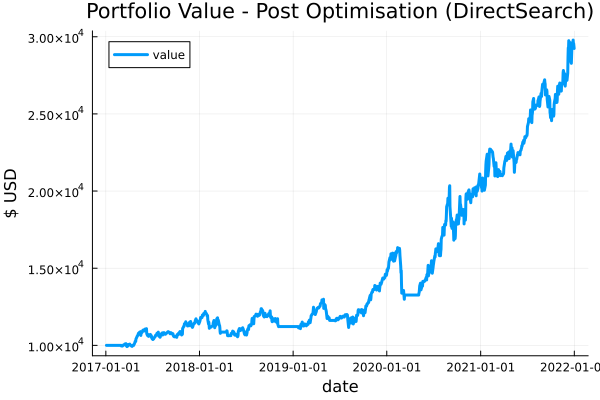

In [16]:



using Plots: plot, plot!
plot(results.date, results.dollarValue, title="Portfolio Value - Post Optimisation (DirectSearch)", label="value", linewidth=3, xlabel="date",ylabel="\$ USD")